In [28]:
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.ImageOps    

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from tqdm.notebook import tqdm, trange
import pandas as pd
from model import *
!nvidia-smi

Wed Mar 23 00:49:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 462.35       Driver Version: 462.35       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 306... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   40C    P0    22W /  N/A |    121MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [25]:
dataset_keys = pd.read_csv("./dataset/verification/verification_dev.csv")
dataset_keys.match = dataset_keys.match.map(lambda x: np.float32(not x))
dataset_keys.head()

,image_A,image_B,match
0,dev/ab001b21a1.jpg,dev/10246770ce.jpg,0.0
1,dev/c692b5fa6b.jpg,dev/299becf799.jpg,1.0
2,dev/d0dc5318e4.jpg,dev/3aac902136.jpg,1.0
3,dev/f9643ca7b5.jpg,dev/6f300f3205.jpg,0.0
4,dev/95ccb4131a.jpg,dev/3d207ca2b2.jpg,1.0


In [33]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=4.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive

In [80]:
class VarificationDataset(Dataset):
    def __init__(self, keys, path = "./dataset/verification/", transform = None):
        
        
        self.keys = keys.reset_index()
        self.path = path
        self.transform = transform
    def __len__(self):
        return len(self.keys)
    def __getitem__(self,index):
        
        key = self.keys.loc[index]
        image_A = Image.open(self.path+key.image_A)
        image_B = Image.open(self.path+key.image_B)
        label = key.match
        image_A.convert("RGB")
        image_B.convert("RGB")
        
        if self.transform is not None:
            image_A = self.transform(image_A)
            image_B = self.transform(image_B)
            
        return image_A, image_B, torch.from_numpy(np.array([label],dtype = np.float32))
        

In [81]:
idx = np.random.permutation(len(dataset_keys))
spl = int(0.8*len(dataset_keys))
train_keys = dataset_keys.loc[idx[:spl]]
val_keys = dataset_keys.loc[idx[spl:]]

In [87]:
train_set = VarificationDataset(train_keys,transform=transforms.ToTensor())
train_loader = DataLoader(train_set,batch_size=128, shuffle=True)
val_set = VarificationDataset(val_keys,transform=transforms.ToTensor())
val_loader = DataLoader(val_set,batch_size=128, shuffle=True)

In [91]:
model= SiameseNetwork(3)
model = model.to("cuda")
loss_fn = ContrastiveLoss()

train_loss_list = []
val_loss_list = []

In [92]:
epochs = 10

loop = trange(epochs)
optimizer = torch.optim.AdamW(model.parameters(),1e-3)

for epoch in loop:
    running_loss = 0
    model.train()
    for X1 ,X2 ,y in tqdm(train_loader,"training",leave=False):
        X1, X2 , y = X1.to("cuda") ,X2.to("cuda") ,y.to("cuda")
        optimizer.zero_grad()
        out1, out2= model(X1, X2)
        loss = loss_fn(out1, out2, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    loss = running_loss/len(train_loader)
    train_loss_list.append(loss)
    running_loss = 0
    with torch.no_grad():
        model.eval()
        running_loss = 0
        for X1 ,X2 ,y in tqdm(val_loader,"validation",leave = False):
            X1, X2 , y = X1.to("cuda") ,X2.to("cuda") ,y.to("cuda")
            out1, out2= model(X1, X2)
            loss = loss_fn(out1, out2, y)
            running_loss += loss.item()

    loss = running_loss/len(val_loader)
    val_loss_list.append(loss)
    loop.set_postfix(dict(train_loss = train_loss_list[-1], val_loss = val_loss_list[-1]))
        
    

  0%|          | 0/10 [00:00<?, ?it/s]

training:   0%|          | 0/1043 [00:00<?, ?it/s]

validation:   0%|          | 0/261 [00:00<?, ?it/s]

training:   0%|          | 0/1043 [00:00<?, ?it/s]

validation:   0%|          | 0/261 [00:00<?, ?it/s]

training:   0%|          | 0/1043 [00:00<?, ?it/s]

validation:   0%|          | 0/261 [00:00<?, ?it/s]

training:   0%|          | 0/1043 [00:00<?, ?it/s]

validation:   0%|          | 0/261 [00:00<?, ?it/s]

training:   0%|          | 0/1043 [00:00<?, ?it/s]

validation:   0%|          | 0/261 [00:00<?, ?it/s]

training:   0%|          | 0/1043 [00:00<?, ?it/s]

validation:   0%|          | 0/261 [00:00<?, ?it/s]

training:   0%|          | 0/1043 [00:00<?, ?it/s]

validation:   0%|          | 0/261 [00:00<?, ?it/s]

training:   0%|          | 0/1043 [00:00<?, ?it/s]

validation:   0%|          | 0/261 [00:00<?, ?it/s]

training:   0%|          | 0/1043 [00:00<?, ?it/s]

validation:   0%|          | 0/261 [00:00<?, ?it/s]

training:   0%|          | 0/1043 [00:00<?, ?it/s]

validation:   0%|          | 0/261 [00:00<?, ?it/s]

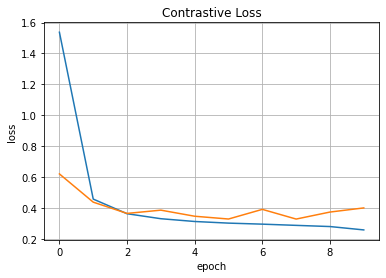

In [96]:
plt.plot(train_loss_list,label = "train")
plt.plot(val_loss_list,label = "validation")
plt.title("Contrastive Loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid("on")

In [101]:
with torch.no_grad():
    outs1 = torch.zeros(len(train_set),30)
    outs2 = torch.zeros_like(outs1)
    labels = torch.zeros(len(train_set))
    for i, (X1 ,X2 ,y) in tqdm(enumerate(train_set),"embedding_training",leave=False
                              ,total = len(train_set)):
        X1, X2 = X1.to("cuda") ,X2.to("cuda") 
        optimizer.zero_grad()
        X1 = torch.unsqueeze(X1,0)
        X2 = torch.unsqueeze(X2,0)
        out1, out2= model(X1, X2)
        outs1[i,:] = out1.to("cpu")
        outs2[i,:] = out2.to("cpu")
        labels[i] = y
        if i == len(train_set)-1:
            break
        
X1_train = outs1.numpy()
X2_train = outs2.numpy()
y_train = labels.numpy()

embedding_training:   0%|          | 0/133440 [00:00<?, ?it/s]

In [102]:
with torch.no_grad():
    outs1 = torch.zeros(len(val_set),30)
    outs2 = torch.zeros_like(outs1)
    labels = torch.zeros(len(val_set))
    for i, (X1 ,X2 ,y) in tqdm(enumerate(val_set),"embedding_training",leave=False
                              ,total = len(val_set)):
        X1, X2 = X1.to("cuda") ,X2.to("cuda") 
        optimizer.zero_grad()
        X1 = torch.unsqueeze(X1,0)
        X2 = torch.unsqueeze(X2,0)
        out1, out2= model(X1, X2)
        outs1[i,:] = out1.to("cpu")
        outs2[i,:] = out2.to("cpu")
        labels[i] = y
        if i == len(val_set)-1:
            break
X1_val = outs1.numpy()
X2_val = outs2.numpy()
y_val = labels.numpy()

embedding_training:   0%|          | 0/33360 [00:00<?, ?it/s]

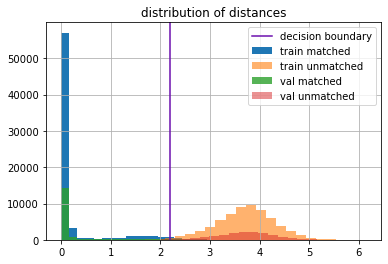

In [169]:
distances = np.linalg.norm(X1_train-X2_train,axis=1)
plt.hist(distances[y_train==0],bins=25,label = "train matched")
plt.hist(distances[y_train==1],bins=25, alpha=0.6,label = "train unmatched")
distances = np.linalg.norm(X1_val-X2_val,axis=1)
plt.hist(distances[y_val==0],bins=25,alpha = 0.8,label = "val matched")
plt.hist(distances[y_val==1],bins=25, alpha=0.5,label = "val unmatched")
plt.axvline(2.2,color = '#6a0dad',label = "decision boundary")
plt.title("distribution of distances")
plt.legend()
plt.grid("on")
plt.show()

In [138]:
def classifier(X1,X2,margin):
    distances = np.linalg.norm(X1-X2,axis=1)
    prediction = np.float32(distances>=margin)
    return prediction
    

In [139]:
y_pred = classifier(X1_val,X2_val,2.2)

In [140]:
from sklearn import metrics

In [141]:
metrics.accuracy_score(y_val,y_pred)

0.9829736211031175

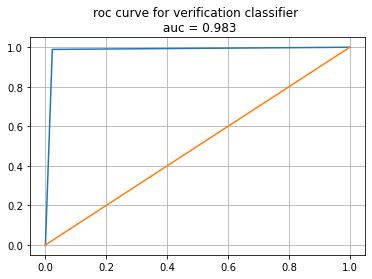

In [162]:
fpr,tpr,_ = metrics.roc_curve(y_val,y_pred)
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1])
plt.title(f"roc curve for verification classifier \n auc = {metrics.roc_auc_score(y_val,y_pred):.3f}")
plt.grid("on")

Text(0.5, 1.0, 'Confusion Matrix')

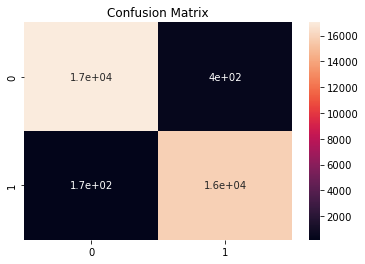

In [161]:
import seaborn as sns
sns.heatmap(metrics.confusion_matrix(y_val,y_pred),annot=True)
plt.title("Confusion Matrix")